# Predict bad LS moves

This notebook develops simple models for predicting bad local search moves. Particularly, given nodes $U$ and $V$ in routes $R_U$ and $R_V$, it predicts whether each LS operator we currently have is likely to produce an improving solution if the operator were applied to these node pairs $U$ and $V$.

The motivation is that evaluating a full operator move is typically somewhat slow, whereas a fast and reasonably accurate prediction method can completely avoid such evaluations.

TODO:
- New data on all U/V combinations, not just neighbourhood restricted.
- Penalties? For feasibility?
- Learning rate and validation stuff?
- Better feature generation

In [1]:
%cd ..

D:\Projects\Python\Euro-NeurIPS-2022


In [2]:
%matplotlib inline

In [3]:
from collections import defaultdict
from dataclasses import dataclass
from glob import glob
import itertools
from pathlib import Path
import re

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

import tools

In [4]:
DATA_PATH = Path("data/raw/")
INST_PATH = Path("instances/")

## Utilities

These can be used to quickly parse the raw results for a single instance into something that contains the same data, but in a more workable format.

In [5]:
@dataclass
class Record:
    op: int
    U: int
    V: int
    delta: int
    Ru: list[int]
    Rv: list[int]

def parse_file(file: str):
    def parse_record(record: list[str]) -> Record:
        op = int(record[0].strip())
        U, V, delta = map(int, record[1].strip().split(" "))
        _, *Ru = map(int, re.findall('[0-9]+', record[2].strip()))
        _, *Rv = map(int, re.findall('[0-9]+', record[3].strip()))

        return Record(op, U, V, delta, Ru, Rv)

    with open(file, 'r') as fh:
        args = [iter(fh)] * 4
        records = zip(*args)

        # This could have been a generator, but each file is only 100-ish MB
        # in size, so that comfortably fits in memory.
        return [parse_record(record) for record in records]

## Data and feature generation

In [6]:
instance_locs = sorted(list(INST_PATH.glob("ORTEC-*.txt")))
data_locs = sorted(list(DATA_PATH.glob("ORTEC-*.txt")))

Operators:

0. $(1, 0)$-Exchange
1. $(2, 0)$-Exchange
2. $(2, 0)$-Reverse-Exchange
3. $(2, 2)$-Exchange
4. $(2, 1)$-Exchange
5. $(1, 1)$-Exchange
6. 2-OPT

In [7]:
def make_features(instance, records):
    dist = instance['duration_matrix']
    dist_max = dist.max()

    loads = instance['demands']
    tw = instance['time_windows']
    max_tw_range = tw[0, 1]

    # TODO operator specific stuff

    data = []
    num_features = 10

    for record in records:
        if record.op == 6:
            # TODO 2-OPT?
            data.append([0] * num_features)
            continue

        idx_u = record.Ru.index(record.U) if record.U != 0 else -1
        idx_v = record.Rv.index(record.V) if record.V != 0 else -1

        # TODO distances should depend on operator
        pu = 0 if idx_u <= 0 else record.Ru[idx_u - 1]
        pv = 0 if idx_v <= 0 else record.Rv[idx_v - 1]

        nu = 0 if idx_u == len(record.Ru) - 1 else record.Ru[idx_u + 1]
        nv = 0 if idx_v == len(record.Rv) - 1 else record.Rv[idx_v + 1]

        # Distances
        dist_puv = dist[pu, record.V] / dist_max
        dist_pvu = dist[pv, record.U] / dist_max

        dist_uv = dist[record.V, record.U] / dist_max
        dist_vu = dist[record.U, record.V] / dist_max

        dist_nvu = dist[nv, record.U] / dist_max
        dist_nuv = dist[nu, record.V] / dist_max
        
        # Time window range
        tw_u_start, tw_u_end = tw[record.U]
        tw_u_range = (tw_u_end - tw_u_start) / max_tw_range

        tw_v_start, tw_v_end = tw[record.V]
        tw_v_range = (tw_v_end - tw_v_start) / max_tw_range

        # Load feasibility
        load_u = loads[record.Ru].sum()
        load_v = loads[record.Rv].sum()
        
        u_load_feasible = load_u <= instance['capacity']
        v_load_feasible = load_v <= instance['capacity']

        data.append([dist_puv, dist_pvu, dist_uv, dist_vu, dist_nvu, dist_nuv, tw_u_range, tw_v_range, u_load_feasible, v_load_feasible])

    return np.array(data)

In [8]:
def make_data(file_loc: str):
    instance = tools.read_vrplib(INST_PATH / file_loc)
    records = parse_file(DATA_PATH / file_loc)

    y = np.array([int(record.delta < 0) for record in records])
    X = make_features(instance, records)

    return X, y

## Training

In [9]:
X_train, y_train = make_data('ORTEC-VRPTW-ASYM-1de83915-d1-n262-k15.txt')
X_test, y_test = make_data('ORTEC-VRPTW-ASYM-e7835db2-d1-n650-k42.txt')

Class weight appears to be roughly ~0.3% for number of improving moves afer 10s. See next figure:

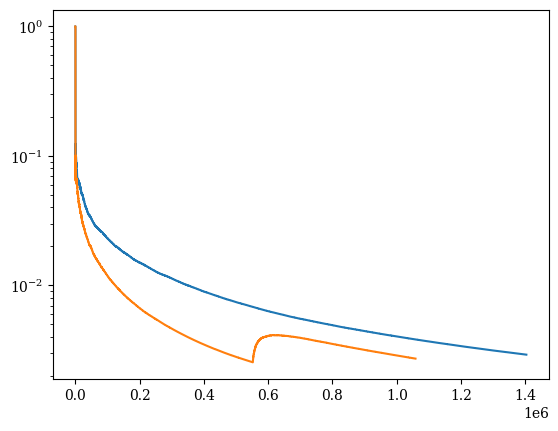

In [10]:
_, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(np.cumsum(y_test) / np.arange(1, len(y_test) + 1))
ax.plot(np.cumsum(y_train) / np.arange(1, len(y_train) + 1));

In [11]:
weights = {0: 1, 1: 1 / 0.003}
model = SGDClassifier(loss="log_loss", class_weight=weights)

In [12]:
for _ in range(5):
    model.partial_fit(X_train, y_train, [0, 1]);

## Evaluation

In [13]:
print(X_train[y_train == 0].mean(axis=0))
print(X_train[y_train == 1].mean(axis=0))

[0.16442609 0.17050385 0.14470164 0.14468737 0.16081794 0.16933335
 0.15998867 0.22204005 0.84266283 0.84046373]
[0.14269985 0.18768104 0.10475206 0.10524497 0.18261067 0.17398975
 0.17095515 0.18456311 0.74653259 0.79923717]


In [14]:
y_pred = model.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.998     0.889     0.940   1399285
           1      0.009     0.345     0.018      4103

    accuracy                          0.887   1403388
   macro avg      0.503     0.617     0.479   1403388
weighted avg      0.995     0.887     0.938   1403388



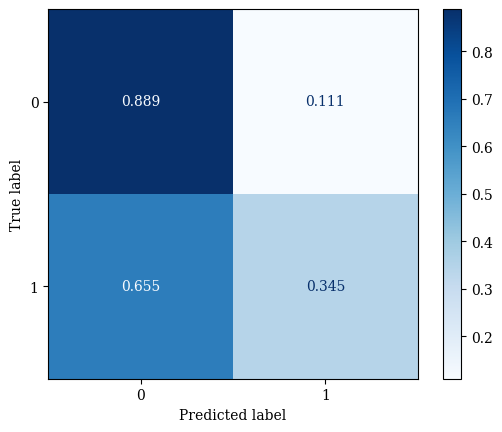

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues', values_format=".3f")

In [17]:
print(*model.coef_[0], sep='\n')

0.3691249364542134
4.102854803416633
-7.910097083426576
-5.397763770218305
2.0060761164817342
2.370644919101056
1.939525052240538
2.722924673606389
-1.508545923323888
0.14267628806487873
